# Analyse synthesis outputs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav
import scatcovjax.plotting as plot


# Parameters

In [49]:
reality = True
sampling = 'mw'
multiresolution = True
L = 32
N = 3
epochs = 10
J_min = 0

J = s2wav.utils.shapes.j_max(L)
print(J)

axi = True if N == 1 else False  # Axisym or directional

5


# Make filters

(<Figure size 800x600 with 1 Axes>, <Axes: >)

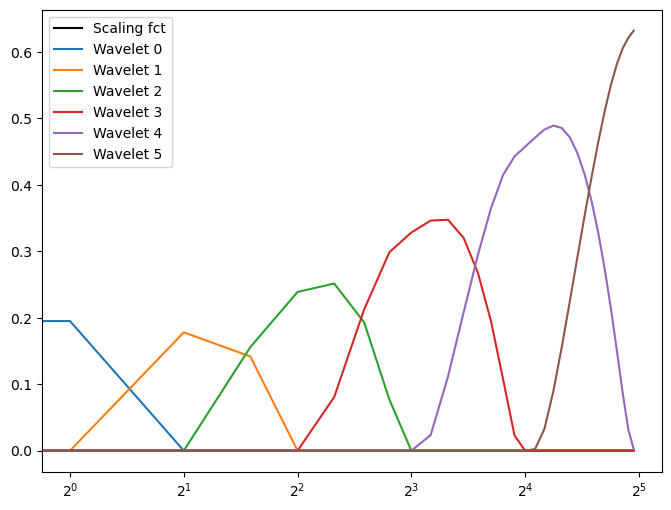

In [37]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=True, m=L-1)

# Load the data

In [39]:
# List of job with these parameters
job_list = glob.glob(f'../scripts/outputs/*L{L}_N{N}_epochs{epochs}')
print(job_list)

# Choose the run
run = 1
output_dir = job_list[run]

# flm
flm_target = np.load(output_dir + '/flm_target.npy')
flm_start = np.load(output_dir + '/flm_start.npy')
flm_end = np.load(output_dir + '/flm_end.npy')
print(flm_end.shape)

# Loss
loss_history = np.load(output_dir + '/loss.npy')

# Coeffs
tmean, tvar, tS1, tP00, tC01, tC11 = np.load(output_dir + '/coeffs_target.npy', allow_pickle=True)
smean, svar, sS1, sP00, sC01, sC11 = np.load(output_dir + '/coeffs_start.npy', allow_pickle=True)
emean, evar, eS1, eP00, eC01, eC11 = np.load(output_dir + '/coeffs_end.npy', allow_pickle=True)

['../scripts/outputs/Job6002_L32_N3_epochs10', '../scripts/outputs/Job6003_L32_N3_epochs10', '../scripts/outputs/Job6001_L32_N3_epochs10']
(32, 32)


In [40]:
if reality:  # Get the full flm
    flm_target = sphlib.make_flm_full(flm_target, L)
    flm_start = sphlib.make_flm_full(flm_start, L)
    flm_end = sphlib.make_flm_full(flm_end, L)
print(flm_end.shape)

(32, 63)


In [41]:
# Make the maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_end, L, reality=reality)

# Plots

Text(0.5, 0, 'Number of iterations')

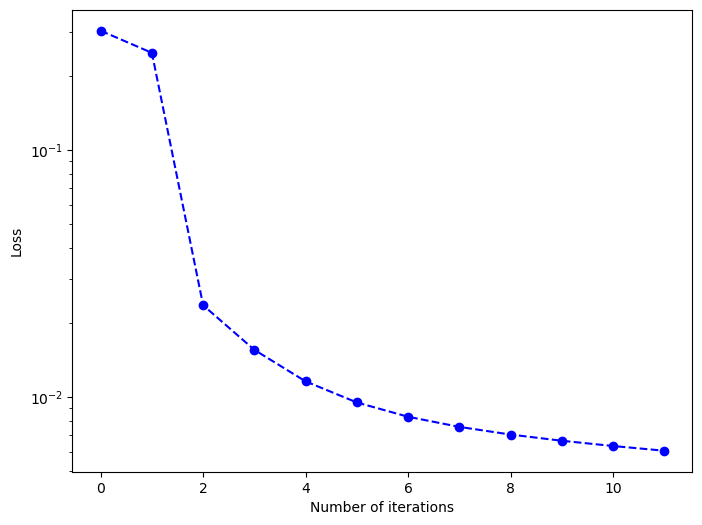

In [42]:
plt.figure(figsize=(8, 6))
# plt.plot(np.arange(0, 60, 10), loss_history, 'bo--')
plt.plot(loss_history, 'bo--')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

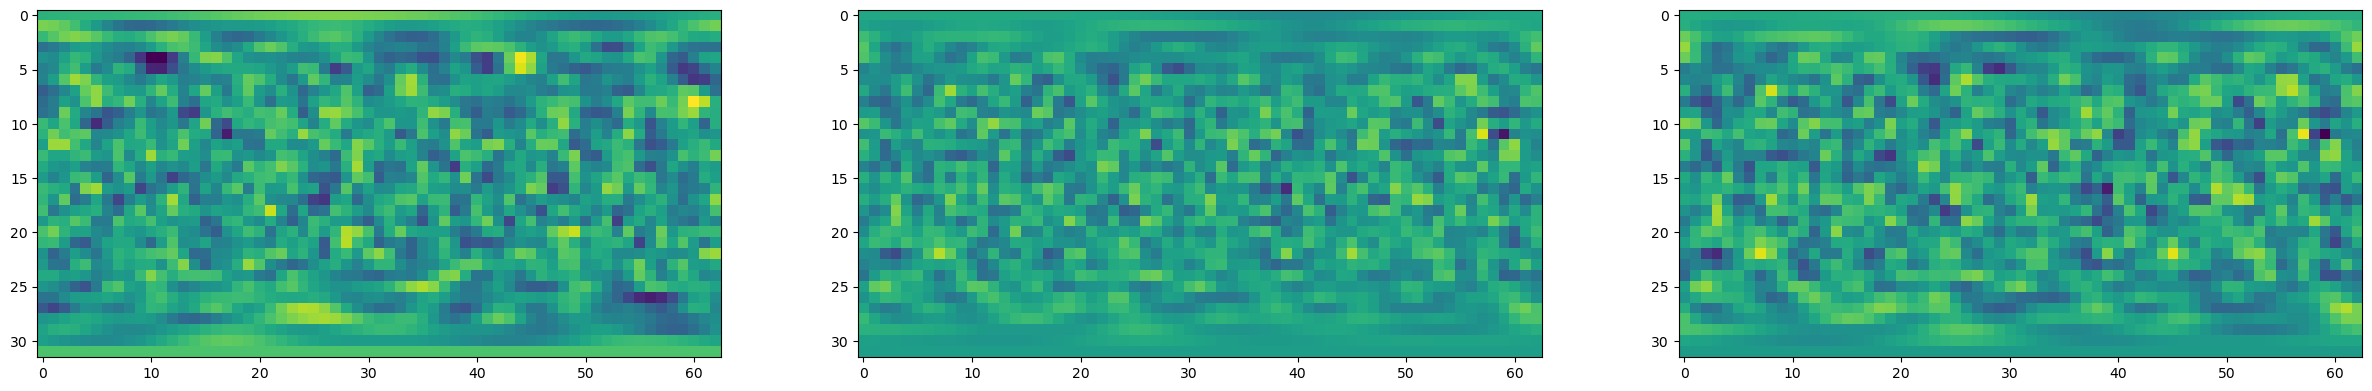

In [43]:
mx, mn = np.nanmax(f_target), np.nanmin(f_target)

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
ax1.imshow(f_target, vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(f_start, vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

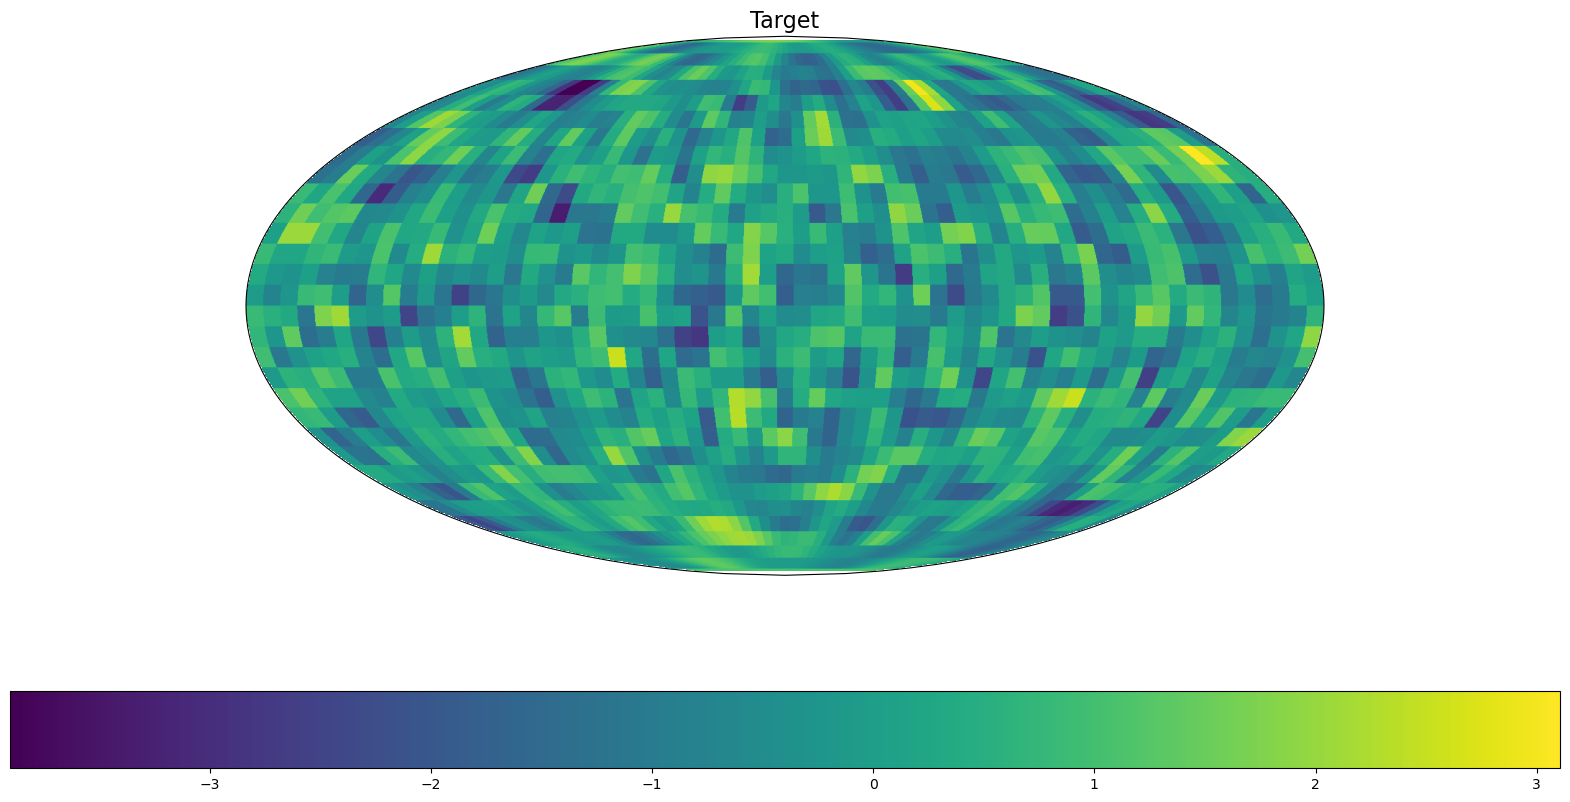

In [44]:
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title='Target', figsize=(20, 10))

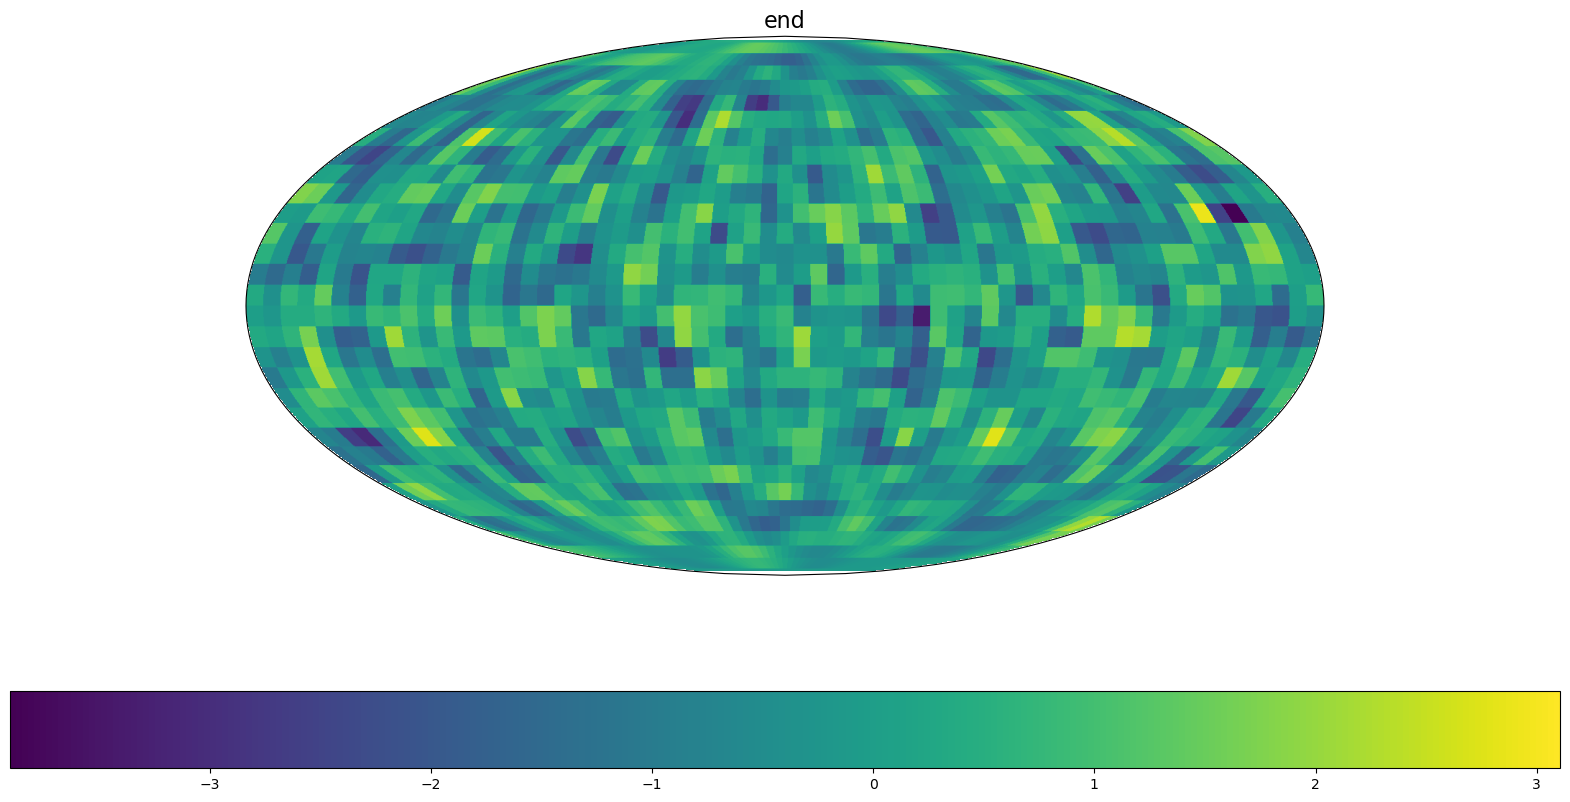

In [45]:
plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, title='end', figsize=(20, 10))

### Power spectrum

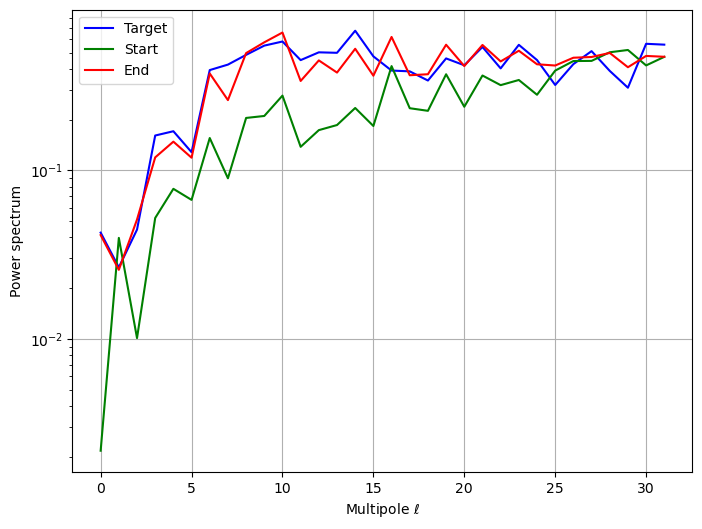

In [46]:
ps_target = sphlib.compute_ps(flm_target)
ps_start = sphlib.compute_ps(flm_start)
ps_end = sphlib.compute_ps(flm_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end, 'r', label="End")
plt.yscale("log")
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
plt.legend()

In [47]:
print('Mean:', tmean, smean, emean)
print('Var:', tvar, svar, evar)

Mean: 0.05828999005580757 0.013136875290243646 0.05732079398843329
Var: 0.006445054683119957 0.004139765080986293 0.006329757817636241


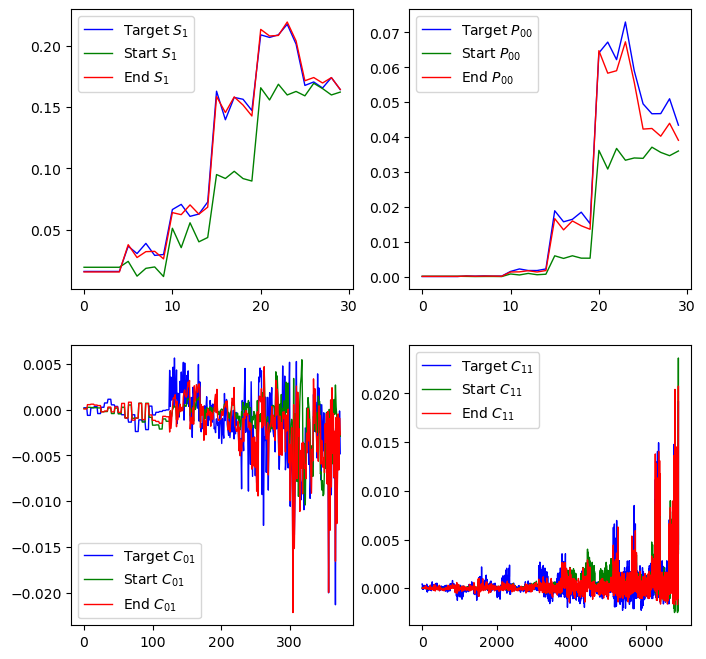

In [48]:
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue', lw=1)

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green', lw=1)

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red', lw=1)